<div class="alert alert-block alert-success" align="center" style="font-size:115%">
    <strong>SCS_3547_Final</strong></div>
<div class="alert alert-block alert-success" align="center">
David Signoretti<br>
2020-12-08
</div>

### The Hypthesis
<div class="alert alert-block alert-info" align="center">
How does the Emergency Medical Service position an ambulance to a given geographic region?
</div>

The province is divided into different geographic response areas called "Response Areas." These Response Areas are from a few city blocks to hundreds of square KM. The project was simply a proof of concept that could Deep Q Learning predict the next call's location. Even though geographic boundaries define the response areas, a linear array can represent response areas. A linear numpy array probability distortion where the highest value in the array is the next response location.

It is merely an asymmetrical game with two players: an antagonist (the patients) and a sympathetic (the ambulance).  Both players are allowed to change the state of the game without waiting for their turn. To keep the problem simple to start a single ambulance is used. The DQN tracks the location of the ambulance position using a zero-filled numpy array.

**The hypothesis is --- maybe from the results of a simple model.**

### Method

The DQN Linear network predicts (kind of) the best location to place an ambulance based on the highest probability of a patient location. 

The antagonist (the patient) hyperparameter `ANTAGONISTIC_MOVE_RATE` can change the rate the probability distribution changes the state.  Encapsulated of the antagonist state is linear the numpy array `antagonistic_state.`

By moving the ambulance, the sympathetic changes the ambulance's position as part of the gameplay and the game rewards the sympathetic when in the correct location. The DQN is trying to position the ambulance in the correct location. `sympathetic_state`

            argmax(antagonistic_state) -> [0.02138027 0.01243725 0.32124701 ... ]
            argmax(sympathetic_state) ->  [0             0           1      ...]
            in this example the reward would be 50 because the index of antagonistic_state == sympathetic_state

The movment of the abulance is 0 to move right and 1 to move left and the function `sympathetic_move` handles the move. The function also check to make sure the move is with the array.



### Results

First, although very noisy, the loss rate is decreasing, and the rate the ambulance is at the correct location is increasing. For the first few hundred iterations the loss value increases sharply. After a second spike around 500 iterations and then flattens to around 1500 iterations, the loss rate is continuously decreasing—the prediction of where the ambulance should follow the same trajectory. After approximately 1500 iterations, the predictions start becoming more accurate. 

With more work and experimentation, a DQN could assist in determining where to locate an ambulance.




### imports

In [9]:
import numpy as np
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as op
import collections as cc
import random as rn
from matplotlib import pylab as plt

### Hyperparameters 

In [10]:
device = T.device("cuda" if T.cuda.is_available() else "cpu")

GAMMA: float = 0.99
EXPLORE: int = 20000
EPOCH: int = 100000
MAX_MOVES: int = 2500
INITIAL_EPSILON: float = 0.1
FINAL_EPSILON: float = 0.0001
REPLAY_MEMORY: int = 1000000
BATCH_SIZE: int = 128
LEARNING_RATE: float = 0.0001
ANTAGONISTIC_MOVE_RATE: float = 0.02
STEPS: int = 256

### Function dis( _size: int )
    
- Generate a numpy array with a discrete distribution using softmax
- :param _size:integer size of distribution
- :return:  numpy array


In [11]:
def dis(_size: int):
    _ = np.random.rand(_size)
    _d = np.exp(_) / sum(np.exp(_))
    return _d

##### Class Grid(object) (the game board)

##### Varables 
- `self.state_size: int:` integer the size of the numpy array
- `self.state_prob: np.array (linear):` a probability distribution form 0 to 1 each index is a symbolicr representation of a geographically area. The higher probability would represent a population density. For the more people the greater chance of an ambulance is required
- `self.antagonistic_state: np.array (linear):` Generate a numpy array with a discrete distribution using softmax using the `function def dist(_size: int)` 

            sizeof(state_size) [0.34332772 0.25884159 ... 0.39783069]

- `self.sympathetic_state: np.array (linear):` numpy zero filled array for the current location of an ambulance

            sizeof(state_size) [1 0 0 ... 0] the 1 represents the location of the ambulance
            
- `self.reward: float:` init the reward value

- `self.sympathetic_state:` set the ambulance to index[0]<br>


- :param state_size: the size of the numpy array"

##### Functions
###### antagonistic_move(self, antagonistic_move_rate: float) -> object:

- The idea of the antagonistic_move is to change the state at a given interval based on value of `**antagonistic_move_rate**` and generates a new probability distribution. The value of `ANTAGONISTIC_MOVE_RATE: float = 0.02` will changes the rate that a new antagonistic_state is created.
     
###### sympathetic_move(self, action: int) -> object:
- Move the agent to the left or right by increasing or decreasing the agents current numpy index value. 
    The action check to see the move will be outside the array.
    
- param action: 0 to move right and 1 to move left

###### sympathetic_reward(self) -> object:
       
- The reward method rewards (50) or punishes (-1) the agent if index vale is not equal the index value of the patient.
     
- :return: reward for the agent of the current state

In [12]:
class Grid(object):

    def __init__(self, state_size: int):

        self.state_size: int = state_size
        self.antagonistic_state: np.array = dis(self.state_size)
        self.sympathetic_state: np.array = np.zeros(self.state_size)
        self.sympathetic_state[0] = 1.0
        self.reward: float = 0.0
        self.reward_count = []

    def antagonistic_move(self, antagonistic_move_rate: float) -> object:

        if rn.random() < antagonistic_move_rate:
            self.antagonistic_state = dis(len(self.antagonistic_state))

    def sympathetic_move(self, action: int) -> object:

        if action == 0:
            _idx = self.sympathetic_state.argmax()
            if _idx < (self.sympathetic_state.size - 1):
                self.sympathetic_state[_idx] = 0
                self.sympathetic_state[_idx + 1] = 1
        elif action == 1:
            _idx = self.sympathetic_state.argmax()
            if _idx > 0:
                self.sympathetic_state[_idx] = 0
                self.sympathetic_state[_idx - 1] = 1

    def sympathetic_reward(self) -> object:

        if np.argmax(self.antagonistic_state) == np.argmax(self.sympathetic_state):
            self.reward += 50
        else:
            self.reward -= 1

        self.reward_count.append(self.reward)

### Class LNN(nn.Module)

The class creates a linear neural network with the size `l1, l2, l3 and output_size` as input variables and uses __ReLU__ as the activation function. 

In [13]:
class LNN(nn.Module):

    def __init__(self, l1: int, l2: int, l3: int, output_size: int):
        super(LNN, self).__init__()
        self.linear1 = nn.Linear(l1, l2)
        self.linear2 = nn.Linear(l2, l3)
        self.linear3 = nn.Linear(l3, output_size)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        return x

### Leaning

__See inline comments for details__

In [14]:
#Experience Network (to(device) == cuda)
network_e = LNN(128, 256, 128, 2).to(device)

#Target Network -> network_t
network_t = LNN(128, 256, 128, 2).to(device)

#Load network_e weights into network_t
network_t.load_state_dict(network_e.state_dict())

#Create Adam optimizer
optimizer = op.Adam(network_e.parameters(), lr=LEARNING_RATE)

#local varables
loss_value = []
epsilon = INITIAL_EPSILON
#Create menory buffer
replay_memory = cc.deque(maxlen=REPLAY_MEMORY)
move_count = 0
target = 0
learn_steps = 0
target_sync = 50
reward_count = np.array([])

#Main loop
for _e in range(EPOCH):
    
    #Create new game state for each EPOCH
    game = Grid(128)
    #antagonistic_state to pytorch Tensor
    state_t = T.from_numpy(game.antagonistic_state).float().to(device)

    #Game play
    for steps in range(STEPS):
        move_count += 1
        target += 1

        #Use Epsilon-Greedy or network output
        _rn = rn.random()
        Q = network_e(state_t)
        if _rn < epsilon:
            action_index = rn.randint(0, 1)
        else:
            #Convert tensor to first device==cpu then to numpy array
            Q_ = Q.detach().cpu().numpy()
            action_index = np.argmax(Q_)

        #Make the move from the above 
        game.sympathetic_move(action_index)
         
        #Get the reward from the move above
        game.sympathetic_reward()
        reward_ = game.reward
        reward_count = np.append(reward_count, reward_)

        done = 1 if reward_ > 0 else 0

        #Get the antagonistic_state
        state = game.antagonistic_state
        
        #Get antagonistic_state if the state changes
        game.antagonistic_move(ANTAGONISTIC_MOVE_RATE)
        
        #Set next game state
        state_ = game.antagonistic_state

        #Add experience to memory
        experience = (state, action_index, reward_, state_, done)
        replay_memory.append(experience)

        state = state_

        #Validate the size of the replay_memory if greater than BATCH_SIZE
        if len(replay_memory) > BATCH_SIZE:
            #Get random sample from the memory
            batch_ = rn.sample(replay_memory, BATCH_SIZE)

            #Breaks apart sample of batch
            batch_state = T.tensor([s1 for (s1, a, r, s2, d) in batch_]).float().to(device)
            batch_action = T.tensor([a for (s1, a, r, s2, d) in batch_]).float().to(device)
            batch_reward = T.tensor([r for (s1, a, r, s2, d) in batch_]).float().to(device)
            batch_state_ = T.tensor([s2 for (s1, a, r, s2, d) in batch_]).float().to(device)
            batch_done = T.tensor([d for (s1, a, r, s2, d) in batch_]).to(device)

            #Evalute the batch_state through the experience network
            batch_1 = network_e(batch_state)

            with T.no_grad():
                batch_2 = network_t(batch_state_)

            Y = batch_reward + GAMMA * ((1 - batch_done) * T.max(batch_2, dim=1)[0])
            X = batch_1.gather(dim=1, index=batch_action.long().unsqueeze(dim=1)).squeeze()

            #Using Mean Square Error for loss function
            loss = F.mse_loss(X, Y.detach())
            
            #Backpropagation to calculate the gradients
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_value.append(loss.item())
            
            #target_sync sets when to copy target network     
            if target % target_sync == 0:
                network_t.load_state_dict(network_e.state_dict())

            if epsilon > FINAL_EPSILON:
                epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE
  
    if move_count > MAX_MOVES:
        break

    #if _e % 10 == 0:
     #   T.save(network_e.state_dict(), 'ddqn-policy.para')

### Plots

Text(0, 0.5, 'Loss')

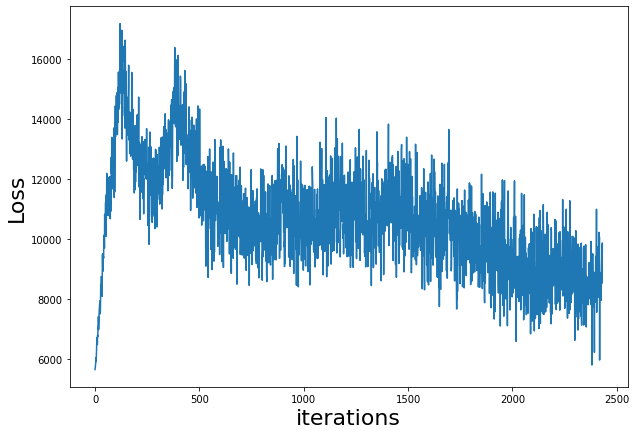

In [15]:
loss_value = np.array(loss_value)
plt.figure(figsize=(10,7))
plt.plot(loss_value)
plt.xlabel("iterations",fontsize=22)
plt.ylabel("Loss",fontsize=22)

Text(0, 0.5, 'Count')

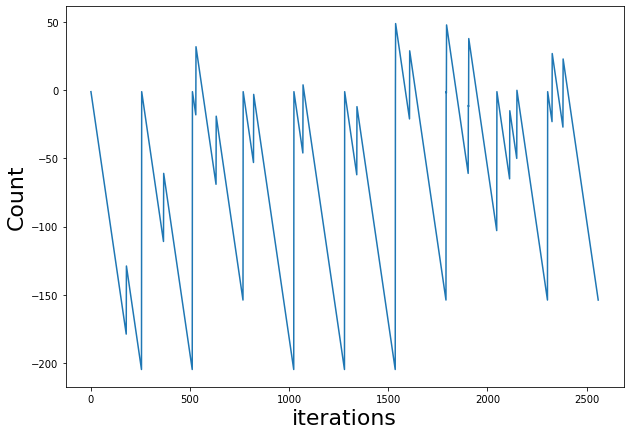

In [16]:
#print(game.reward_count)
plt.figure(figsize=(10,7))
plt.plot(reward_count)
plt.xlabel("iterations",fontsize=22)
plt.ylabel("Count",fontsize=22)